## Understanding Deep Learning 2020
## Multiresolution Representation of Images

#### Hallison Paz
#### October 15th, 2024

In [2]:
import os
from pathlib import Path
import torch

from mrnet.training.trainer import MRTrainer
from mrnet.datasets.signals import ImageSignal
from mrnet.networks.mrnet import MRFactory
from mrnet.datasets.pyramids import create_MR_structure
from mrnet.training.listener import TrainingListener

from mrnet.training.utils import load_hyperparameters, get_optim_handler

In [2]:
CONFIG_PATH = 'code'

### Training a MR-Net Model

In [10]:
torch.manual_seed(777)
#-- hyperparameters in configs --#
hyper = load_hyperparameters('image.yml') #os.path.join(CONFIG_PATH, 'image.yml'))
project_name = hyper.get('project_name', 'framework-tests')

In [17]:
base_signal = ImageSignal.init_fromfile(
                    hyper['data_path'],
                    domain=hyper['domain'],
                    channels=hyper['channels'],
                    sampling_scheme=hyper['sampling_scheme'],
                    width=hyper['width'], height=hyper['height'],
                    batch_size=hyper['batch_size'],
                    color_space=hyper['color_space'])

train_dataset = create_MR_structure(base_signal,
                                    hyper['max_stages'],
                                    hyper['filter'],
                                    False, #hyper['decimation'],
                                    hyper['pmode'])
test_dataset = create_MR_structure(base_signal,
                                    hyper['max_stages'],
                                    hyper['filter'],
                                    False,
                                    hyper['pmode'])

if hyper['width'] == 0:
    hyper['width'] = base_signal.shape[-1]
if hyper['height'] == 0:
    hyper['height'] = base_signal.shape[-1]

# you can substitute this line by your custom handler class
optim_handler = get_optim_handler(hyper.get('optim_handler', 'regular'))

mrmodel = MRFactory.from_dict(hyper)
print("Model: ", type(mrmodel))
name = os.path.basename(hyper['data_path'])
logger = TrainingListener(project_name,
                            f"{hyper['model']}{hyper['filter'][0].upper()}{name[0:7]}{hyper['color_space'][0]}",
                            hyper,
                            Path(hyper.get("log_path", "runs")))
mrtrainer = MRTrainer.init_from_dict(mrmodel,
                                    train_dataset,
                                    test_dataset,
                                    logger,
                                    hyper,
                                    optim_handler=optim_handler)
mrtrainer.train(hyper['device'])

Model:  <class 'mrnet.networks.mrnet.MNet'>
DATA SIZE torch.Size([3, 256, 256])
torch.Size([256, 256, 3]) DEBUG 1
[Logger] All inference done in 1.7008435726165771s on cuda
Total model parameters =  1250
All results logged to runs\logs\20241015_MGmasp.jpR\0208st1-5_w3T_hl1_hf32_Ep1000
DATA SIZE torch.Size([3, 256, 256])
torch.Size([256, 256, 3]) DEBUG 1
[Logger] All inference done in 1.5551340579986572s on cuda
Total model parameters =  7844
All results logged to runs\logs\20241015_MGmasp.jpR\0208st2-5_w4T_hl1_hf64_Ep1000
DATA SIZE torch.Size([3, 256, 256])
torch.Size([256, 256, 3]) DEBUG 1
[Logger] All inference done in 1.6202609539031982s on cuda
Total model parameters =  33318
All results logged to runs\logs\20241015_MGmasp.jpR\0208st3-5_w12T_hl1_hf128_Ep1000
DATA SIZE torch.Size([3, 256, 256])
torch.Size([256, 256, 3]) DEBUG 1
[Logger] All inference done in 1.6375041007995605s on cuda
Total model parameters =  96104
All results logged to runs\logs\20241015_MGmasp.jpR\0209st4-5_w20T

### Exploring the model scales

In [3]:
import ipywidgets as widgets
import numpy as np
from PIL import Image
from ipywidgets import interact, interactive, Box, interact_manual
from mrnet.datasets.sampler import make_grid_coords

In [4]:
modelpath = input("Path to the saved model parameters file: ")
mrmodel = MRFactory.load_state_dict(modelpath)
print('modelpath:', modelpath)

modelpath: E:\Workspace\presentations\udl\runs\logs\20241015_MGmasp.jpR\0209st5-5_w48T_hl1_hf256_Ep1000\models\M_stg5.pth


In [11]:
res = hyper['width']
channels = hyper['channels']
model = mrmodel

level_slider = widgets.FloatSlider(
        value=1.0,
        min=0.0,
        max=float(mrmodel.n_stages()),
        step=0.05,
        description=f'Multilevel',
        disabled=False,
        continuous_update=True,
        readout=True,
        orientation='horizontal',
        readout_format='.2f',
        layout=widgets.Layout(width='50%')
)
def plot_model(level):
    grid = make_grid_coords(res, -1.0, 1.0, dim=2)
    weights = []
    for s in range(mrmodel.n_stages()):
        if level >= s + 1:
             weights.append(1.0)
        else:
             weights.append(max(level - s, 0.0))

    output = model(grid, mrweights=torch.Tensor(weights))
    model_out = torch.clamp(output['model_out'], 0.0, 1.0)

    pixels = model_out.cpu().detach().view(res, res, channels).numpy()
    pixels = (pixels * 255).astype(np.uint8)
    if channels == 1:
        pixels = np.repeat(pixels, 3, axis=-1)
    return Image.fromarray(pixels)

interact(plot_model, level=level_slider)

interactive(children=(FloatSlider(value=1.0, description='Multilevel', layout=Layout(width='50%'), max=5.0, st…

<function __main__.plot_model(level)>

In [12]:
def plot_level(model, level):
    grid = make_grid_coords(res, -1.0, 1.0, dim=2)
    weights = torch.zeros(mrmodel.n_stages())
    weights[level] = 1.0

    output = model(grid, mrweights=torch.Tensor(weights))
    model_out = torch.clamp(output['model_out'], 0.0, 1.0)

    pixels = model_out.cpu().detach().view(res, res, channels).numpy()
    pixels = (pixels * 255).astype(np.uint8)
    if channels == 1:
        pixels = np.repeat(pixels, 3, axis=-1)
    return Image.fromarray(pixels)

def plot_levels(model):
    grid = make_grid_coords(res, -1.0, 1.0, dim=2)
    img_levels = []
    for level in range(mrmodel.n_stages()):
        weights = torch.zeros(mrmodel.n_stages())
        weights[level] = 1.0

        output = model(grid, mrweights=torch.Tensor(weights))
        model_out = torch.clamp(output['model_out'], 0.0, 1.0)

        pixels = model_out.cpu().detach().view(res, res, channels).numpy()
        pixels = (pixels * 255).astype(np.uint8)
        if channels == 1:
            pixels = np.repeat(pixels, 3, axis=-1)
        img_levels.append(pixels)
    return Image.fromarray(np.hstack(tuple(img_levels)))

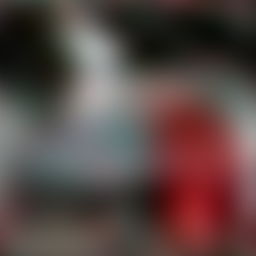

In [23]:
plot_level(model, 0)

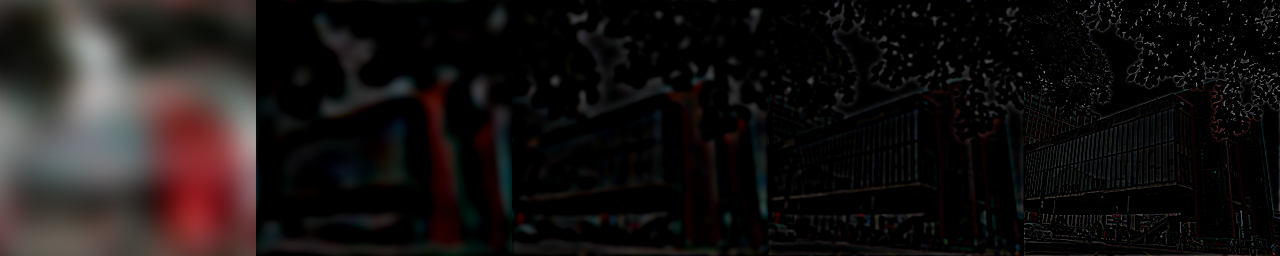

In [28]:
plot_levels(model)

In [13]:
def plot_sum_levels(model):
    grid = make_grid_coords(res, -1.0, 1.0, dim=2)
    img_levels = []
    weights = torch.zeros(mrmodel.n_stages())
    for level in range(mrmodel.n_stages()):
        weights[level] = 1.0

        output = model(grid, mrweights=torch.Tensor(weights))
        model_out = torch.clamp(output['model_out'], 0.0, 1.0)

        pixels = model_out.cpu().detach().view(res, res, channels).numpy()
        pixels = (pixels * 255).astype(np.uint8)
        if channels == 1:
            pixels = np.repeat(pixels, 3, axis=-1)
        img_levels.append(pixels)
    return Image.fromarray(np.hstack(tuple(img_levels)))

In [14]:
stack = plot_sum_levels(model)
stack.save("filtered.png")